<a href="https://colab.research.google.com/github/sai-bharghav/Deep-Learning/blob/main/Neural_Network_Classification_Problems.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import torch
import matplotlib.pyplot as plt

# Device agnostic Code
device = 'cuda' if torch.cuda.is_available() else 'cpu'
device

'cpu'

# 1st Question
Make a binary classification dataset with Scikit-Learn's `make_moons()` function.
* For consistency, the dataset should have 1000 samples and a random_state=42.
* Turn the data into PyTorch tensors. Split the data into training and test sets using train_test_split with 80% training and 20% testing.


In [2]:
from sklearn.datasets import make_moons

n_samples = 1000
X,y = make_moons(n_samples=n_samples,random_state=42)
X[:5],y[:5]

(array([[ 0.00872719,  0.36817352],
        [ 0.921384  , -0.49690497],
        [ 0.94022577, -0.49821192],
        [ 0.46587532, -0.34540571],
        [-0.85041204,  0.52611726]]),
 array([1, 1, 1, 1, 0]))

So the dataset is quite similar to `make_circles` dataset (2 features for X and two values for y)

In [3]:
# Before splitting the data let us convert the data into tensors
X = torch.from_numpy(X).type(torch.float32).to(device)
y = torch.from_numpy(y).type(torch.float32).to(device)

X[:5],y[:5]

(tensor([[ 0.0087,  0.3682],
         [ 0.9214, -0.4969],
         [ 0.9402, -0.4982],
         [ 0.4659, -0.3454],
         [-0.8504,  0.5261]]),
 tensor([1., 1., 1., 1., 0.]))

In [4]:
# Let us check the dtype
X.dtype, y.dtype

(torch.float32, torch.float32)

In [5]:
# Let us split the data
from sklearn.model_selection import train_test_split
X_train,X_test,y_train,y_test = train_test_split(X,y,
                                                 random_state=42,
                                                 test_size=0.2)


In [6]:
torch.manual_seed(42)
torch.cuda.manual_seed(42)

# Device agnostic code
X_train, y_train = X_train.to(device),y_train.to(device)
X_test,y_test = X_test.to(device),y_test.to(device)

In [7]:
# Let us check the shape of each split
X_train.shape,y_train.shape,X_test.shape,y_test.shape

(torch.Size([800, 2]),
 torch.Size([800]),
 torch.Size([200, 2]),
 torch.Size([200]))

In [8]:
X_train[:5],y_train[:5]

(tensor([[ 1.9469,  0.1784],
         [-0.9174,  0.3979],
         [-0.0786,  0.9969],
         [-0.1162,  0.9932],
         [ 0.3737, -0.2796]]),
 tensor([1., 0., 0., 0., 1.]))

Before going to next question let us visualize the data

In [9]:
import requests
from pathlib import Path

# Download helper functions from Learn PyTorch repo (if it's not already downloaded)
if Path('helper_functions.py').is_file():
  print('helper_functions.py already exists, skipping download')
else:
  print('Download helper functions.py')
  request= requests.get("https://raw.githubusercontent.com/mrdbourke/pytorch-deep-learning/main/helper_functions.py")
  with open('helper_functions.py','wb') as f:
    f.write(request.content)

from helper_functions import plot_predictions, plot_decision_boundary,accuracy_fn

helper_functions.py already exists, skipping download


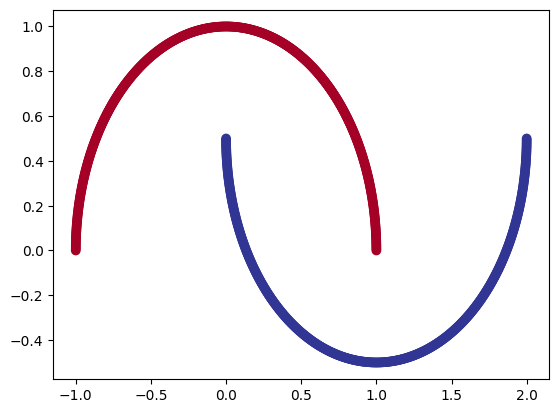

In [10]:
plt.scatter(x=X[:,0],
         y=X[:,1],
         c=y,
         cmap=plt.cm.RdYlBu)

# 2nd Question
Build a model by subclassing `nn.Module` that incorporates non-linear activation functions and is capable of fitting the data you created in 1.
* Feel free to use any combination of PyTorch layers (linear and non-linear) you want.

In [11]:
# Build the model
from torch import nn
class Moons(nn.Module):
  def __init__(self, input_features, output_features,hidden_units=10):
    super().__init__()
    self.linear_layer = nn.Sequential(
        nn.Linear(in_features=input_features,out_features=hidden_units),
        nn.ReLU(),
        nn.Linear(in_features=hidden_units, out_features=hidden_units),
        nn.Linear(in_features=hidden_units,out_features=output_features)
    )

  def forward(self,x):
    return self.linear_layer(x)


In [12]:
model_0 = Moons(input_features=2,output_features=1,hidden_units=10).to(device)
model_0

Moons(
  (linear_layer): Sequential(
    (0): Linear(in_features=2, out_features=10, bias=True)
    (1): ReLU()
    (2): Linear(in_features=10, out_features=10, bias=True)
    (3): Linear(in_features=10, out_features=1, bias=True)
  )
)

# 3rd Question
Setup a binary classification compatible loss function and optimizer to use when training the model.

In [13]:
# Set up the loss function
loss_fn = nn.BCEWithLogitsLoss()

# Setup the optimizer
optimizer = torch.optim.SGD(params = model_0.parameters(),
                            lr=0.1)

# 4th Question
Create a training and testing loop to fit the model you created in 2 to the data you created in 1.
* To measure model accuray, you can create your own accuracy function or use the accuracy function in TorchMetrics.
* Train the model for long enough for it to reach over 96% accuracy.
* The training loop should output progress every 10 epochs of the model's training and test set loss and accuracy.

In [14]:
# Training loop

# Set the number of epochs
epochs = 1000
for epoch in range(epochs):
  ## Training
  model_0.train()

  # 1. Forward pass
  y_logits = model_0(X_train).squeeze()
  y_pred = torch.round(torch.sigmoid(y_logits))

  # 2.Calculate the loss
  loss = loss_fn(y_logits,y_train)
  acc = accuracy_fn(y_true=y_train,y_pred = y_pred)

  # 3. Optimizer zero grad
  optimizer.zero_grad()

  #4. Backward propogation
  loss.backward()

  # 5. Perform gradient descent
  optimizer.step()

  ### TESTING
  model_0.eval()
  with torch.inference_mode():
    # Forward pass
    test_logits = model_0(X_test).squeeze()
    test_pred = torch.round(torch.sigmoid(test_logits))

    # Test loss and accuracy
    test_loss = loss_fn(test_logits,y_test)
    test_acc = accuracy_fn(y_true=y_test, y_pred = test_pred)

  # Print out what's happening
  if epoch % 100==0:
    print(f'Epoch : {epoch} | Loss : {loss} | accuracy : {acc} | test loss : {test_loss} | test accuracy :{test_acc}')

Epoch : 0 | Loss : 0.7164971828460693 | accuracy : 50.0 | test loss : 0.7098251581192017 | test accuracy :50.0
Epoch : 100 | Loss : 0.3297276198863983 | accuracy : 84.25 | test loss : 0.34568727016448975 | test accuracy :79.5
Epoch : 200 | Loss : 0.23525390028953552 | accuracy : 89.0 | test loss : 0.23601704835891724 | test accuracy :91.5
Epoch : 300 | Loss : 0.19618844985961914 | accuracy : 91.625 | test loss : 0.1921698898077011 | test accuracy :92.5
Epoch : 400 | Loss : 0.1596827358007431 | accuracy : 93.375 | test loss : 0.15439453721046448 | test accuracy :94.5
Epoch : 500 | Loss : 0.11781297624111176 | accuracy : 95.5 | test loss : 0.11205019801855087 | test accuracy :96.5
Epoch : 600 | Loss : 0.0790397897362709 | accuracy : 97.75 | test loss : 0.07377225160598755 | test accuracy :98.0
Epoch : 700 | Loss : 0.05123535171151161 | accuracy : 99.625 | test loss : 0.04705873131752014 | test accuracy :99.5
Epoch : 800 | Loss : 0.03416324779391289 | accuracy : 100.0 | test loss : 0.0310

# 5th Question
Make predictions with your trained model and plot them using the `plot_decision_boundary()` function created in this notebook.

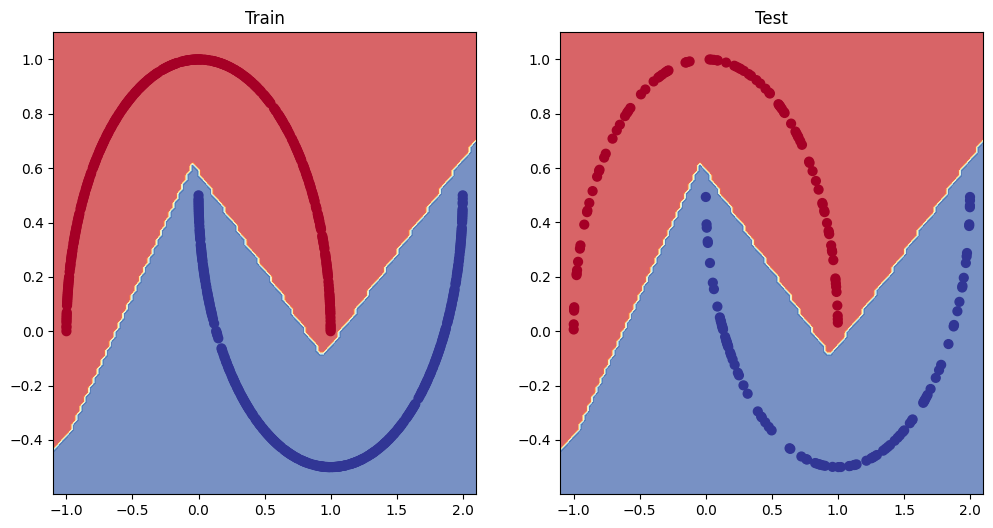

In [15]:
plt.figure(figsize=(12,6))
plt.subplot(1,2,1)
plt.title("Train")
plot_decision_boundary(model_0, X_train,y_train)
plt.subplot(1,2,2)
plt.title('Test')
plot_decision_boundary(model_0,X_test,y_test)

# 6th Question
Replicate the Tanh (hyperbolic tangent) activation function in pure PyTorch.

In [16]:
def tanh(x):
  return ((torch.exp(x)-torch.exp(-x))/torch.exp(x)+torch.exp(-x))

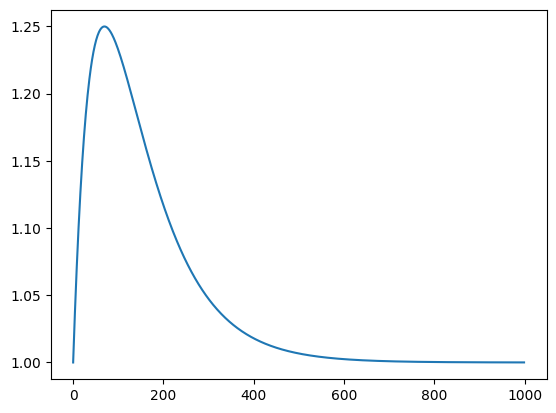

In [22]:
plt.plot(tanh(torch.arange(start=0,end=10,step=0.01)))

# 7th Question
Create a multi-class dataset using the spirals data creation function from CS231n (see below for the code).
* Construct a model capable of fitting the data (you may need a combination of linear and non-linear layers).
* Build a loss function and optimizer capable of handling multi-class data (optional extension: use the Adam optimizer instead of SGD, you may have to experiment with different values of the learning rate to get it working).
* Make a training and testing loop for the multi-class data and train a model on it to reach over 95% testing accuracy (you can use any accuracy measuring function here that you like).
* Plot the decision boundaries on the spirals dataset from your model predictions, the `plot_decision_boundary()` function should work for this dataset too.

```
# Code for creating a spiral dataset from CS231n
import numpy as np
N = 100 # number of points per class
D = 2 # dimensionality
K = 3 # number of classes
X = np.zeros((N*K,D)) # data matrix (each row = single example)
y = np.zeros(N*K, dtype='uint8') # class labels
for j in range(K):
  ix = range(N*j,N*(j+1))
  r = np.linspace(0.0,1,N) # radius
  t = np.linspace(j*4,(j+1)*4,N) + np.random.randn(N)*0.2 # theta
  X[ix] = np.c_[r*np.sin(t), r*np.cos(t)]
  y[ix] = j
# lets visualize the data
plt.scatter(X[:, 0], X[:, 1], c=y, s=40, cmap=plt.cm.Spectral)
plt.show()
```

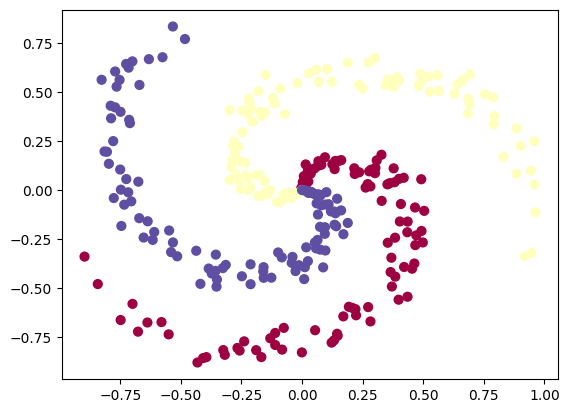

In [23]:
# Code for creating a spiral dataset from CS231n
import numpy as np
N = 100 # number of points per class
D = 2 # dimensionality
K = 3 # number of classes
X = np.zeros((N*K,D)) # data matrix (each row = single example)
y = np.zeros(N*K, dtype='uint8') # class labels
for j in range(K):
  ix = range(N*j,N*(j+1))
  r = np.linspace(0.0,1,N) # radius
  t = np.linspace(j*4,(j+1)*4,N) + np.random.randn(N)*0.2 # theta
  X[ix] = np.c_[r*np.sin(t), r*np.cos(t)]
  y[ix] = j
# lets visualize the data
plt.scatter(X[:, 0], X[:, 1], c=y, s=40, cmap=plt.cm.Spectral)
plt.show()

In [25]:
# Before splitting the data let us convert the data into tensors
X=torch.from_numpy(X).type(torch.float32)
y=torch.from_numpy(y).type(torch.LongTensor)
# Split the data
X_train,X_test, y_train,y_test = train_test_split(X,y,
                                                  random_state=42,
                                                  test_size=0.2)

# Let us check the shape of the split
X_train.shape,X_test.shape,y_train.shape,y_test.shape

(torch.Size([240, 2]),
 torch.Size([60, 2]),
 torch.Size([240]),
 torch.Size([60]))

In [26]:
# Let us write the device agnostic code for it
X_train,y_train = X_train.to(device),y_train.to(device)
X_test,y_test = X_test.to(device),y_test.to(device)

In [33]:
# Build a model for the multiclass
class Spiral(nn.Module):
  def __init__(self,input_units,out_units,hidden_units=8):
    super().__init__()
    self.linear_layer = nn.Sequential(
        nn.Linear(in_features=input_units,out_features=hidden_units),
        nn.ReLU(),
        nn.Linear(in_features=hidden_units,out_features=hidden_units),
        nn.ReLU(),
        nn.Linear(in_features=hidden_units,out_features=out_units)
    )

  def forward(self,x):
    return self.linear_layer(x)

model_1 = Spiral(input_units = 2,out_units=3,hidden_units=8).to(device)
model_1

Spiral(
  (linear_layer): Sequential(
    (0): Linear(in_features=2, out_features=8, bias=True)
    (1): ReLU()
    (2): Linear(in_features=8, out_features=8, bias=True)
    (3): ReLU()
    (4): Linear(in_features=8, out_features=3, bias=True)
  )
)

In [34]:
# Create a loss function and optimizer
loss_fn = nn.CrossEntropyLoss()

# Setup an optimizer
optimizer = torch.optim.Adam(
    params = model_1.parameters(),
    lr=0.1
)

In [37]:
# Check the initial predictions
model_1.eval()
with torch.inference_mode():
  y_logits = model_1(X_train).to(device)
y_logits[:5]

tensor([[0.3023, 0.1104, 0.1317],
        [0.2819, 0.1046, 0.1300],
        [0.3152, 0.0937, 0.1192],
        [0.2617, 0.0406, 0.0671],
        [0.2762, 0.0168, 0.0476]])

In [40]:
y_pred_probs = torch.softmax(y_logits,dim=1).argmax(dim=1)
y_pred_probs[:5]

tensor([0, 0, 0, 0, 0])

In [41]:
y_train[:5]

tensor([2, 0, 0, 1, 1])

In [42]:
# Build the training loop

# Set the number of epochs
epochs = 1000

for epoch in range(epochs):
  ### TRAINING
  # 1 .Forward pass
  y_logits = model_1(X_train)
  y_pred_probs = torch.softmax(y_logits,dim=1).argmax(dim=1)

  # 2. Calcualte the loss
  loss = loss_fn(y_logits,y_train)
  acc = accuracy_fn(y_true = y_train, y_pred = y_pred_probs)

  # 3.Optimizer zero grad
  optimizer.zero_grad()

  # 4. Back propogation
  loss.backward()

  #5. Perform gradient descent
  optimizer.step()

  ### TESTING
  model_1.eval()
  with torch.inference_mode():
    # 1. Forward pass
    test_logits = model_1(X_test)
    test_pred_probs = torch.softmax(test_logits,dim=1).argmax(1)
    #2. Loss and accuracy
    test_loss = loss_fn(test_logits,y_test)
    test_pred_probs = accuracy_fn(y_true=y_test,y_pred = test_pred_probs)

  # Print out what's happening
  if epoch%100==0:
    print(f'Epoch : {epoch} | loss : {loss} | accuracy training : {acc} | test loss :{test_loss} | test_accuracy : {test_acc}')


Epoch : 0 | loss : 1.1136505603790283 | accuracy training : 32.5 | test loss :1.0773950815200806 | test_accuracy : 100.0
Epoch : 100 | loss : 0.03852866590023041 | accuracy training : 99.16666666666667 | test loss :0.01028659287840128 | test_accuracy : 100.0
Epoch : 200 | loss : 0.02551325410604477 | accuracy training : 99.16666666666667 | test loss :0.002303555142134428 | test_accuracy : 100.0
Epoch : 300 | loss : 0.021101074293255806 | accuracy training : 99.16666666666667 | test loss :0.0007875387673266232 | test_accuracy : 100.0
Epoch : 400 | loss : 0.018604444339871407 | accuracy training : 99.16666666666667 | test loss :0.00034560722997412086 | test_accuracy : 100.0
Epoch : 500 | loss : 0.01686820387840271 | accuracy training : 99.16666666666667 | test loss :0.0006321847322396934 | test_accuracy : 100.0
Epoch : 600 | loss : 0.015942923724651337 | accuracy training : 99.16666666666667 | test loss :0.0009205464739352465 | test_accuracy : 100.0
Epoch : 700 | loss : 0.014918254688382

In [44]:
y_train[:5]

tensor([2, 0, 0, 1, 1])

In [46]:
model_1.eval()
with torch.inference_mode():
  y_logits = model_1(X_train).to(device)
  y_pred_probs = torch.softmax(y_logits,dim=1).argmax(dim=1)
y_pred_probs[:5]

tensor([2, 0, 0, 1, 1])

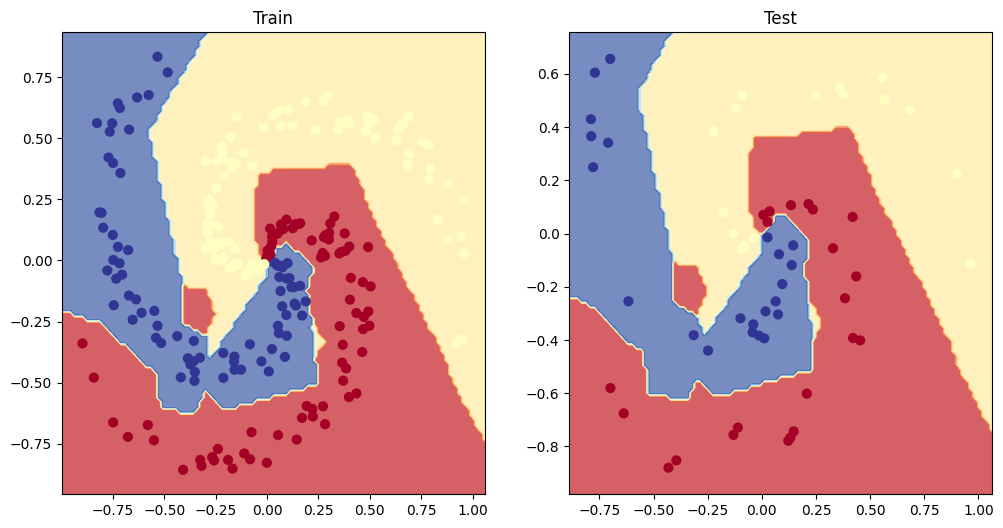

In [47]:
plt.figure(figsize=(12,6))
plt.subplot(1,2,1)
plt.title("Train")
plot_decision_boundary(model_1, X_train,y_train)
plt.subplot(1,2,2)
plt.title('Test')
plot_decision_boundary(model_1,X_test,y_test)